<a href="https://colab.research.google.com/github/raviyk/recommendersys/blob/movielens/Session_embed_2_spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [4]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-08-27 10:46:45--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2020-08-27 10:46:46 (11.6 MB/s) - ‘spam.csv’ saved [503663/503663]



In [7]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [9]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df = df.drop(['Unnamed: 2',	'Unnamed: 3',	'Unnamed: 4'], axis = 1)

In [15]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
df.columns = ['labels', 'data']

In [17]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values#convert to numpy array

In [19]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [20]:
Y

array([0, 0, 1, ..., 0, 0, 0])

In [21]:
#split the data 
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [23]:
#Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train) #Fit only on the train dataset
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [30]:
#get word index mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens' % V)

Found 7282 unique tokens


In [35]:
#pad seq so that we have a NxT matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor: ', data_train.shape)
T = data_train.shape[1] #If test dataset contains longer sentences, it will be truncated
print(T)

Shape of data train tensor:  (3733, 189)
189


In [41]:
#pad seq so that we have a NxT matrix
data_test = pad_sequences(sequences_test)
print('Shape of data train tensor: ', data_test.shape)

Shape of data train tensor:  (1839, 98)


In [37]:
#Create the model 

#Set embedding dimention
D = 20

#Hidden state dimentionality
M = 15

i = Input(shape=(T,))
x = Embedding(V+1, D)(i) #to index, size of array must be '+1'
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x) #works well for long term dependency
x = Dense(1, activation='sigmoid')(x) #spam classification is binary

model = Model(i, x)


In [38]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 20)           145660    
_________________________________________________________________
lstm (LSTM)                  (None, 189, 15)           2160      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 147,836
Trainable params: 147,836
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    epochs=10,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 [==============================] - 8s 70ms/step - loss: 0.4795 - accuracy: 0.8473 - val_loss: 0.3846 - val_accuracy: 0.8711
Epoch 2/10
117/117 [==============================] - 8s 66ms/step - loss: 0.3984 - accuracy: 0.8634 - val_loss: 0.3833 - val_accuracy: 0.8711
Epoch 3/10
117/117 [==============================] - 8s 66ms/step - loss: 0.3964 - accuracy: 0.8634 - val_loss: 0.3803 - val_accuracy: 0.8711
Epoch 4/10
117/117 [==============================] - 8s 69ms/step - loss: 0.3832 - accuracy: 0.8634 - val_loss: 0.3541 - val_accuracy: 0.8711
Epoch 5/10
117/117 [==============================] - 8s 71ms/step - loss: 0.2812 - accuracy: 0.8795 - val_loss: 0.1676 - val_accuracy: 0.9706
Epoch 6/10
117/117 [==============================] - 8s 70ms/step - loss: 0.1018 - accuracy: 0.9879 - val_loss: 0.0839 - val_accuracy: 0.9875
Epoch 7/10
117/117 [==============================] - 8s 70ms/step - loss: 0.0443 - accuracy: 0.9957 - val_loss: 0.0627 - va

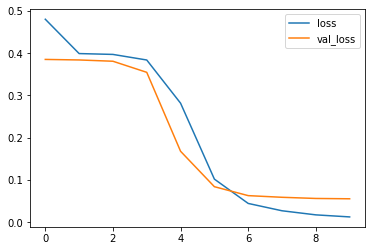

In [43]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

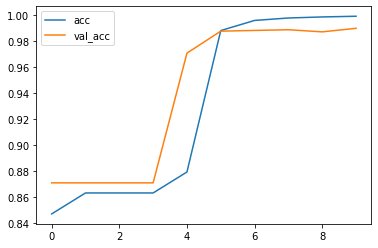

In [44]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()